In [ ]:
# importing needed libraries
import numpy as np
import matplotlib.pyplot as plt
import math

# helper function: expected path length for unsuccessful search in binary tree
def c(n):
    if n <= 1:
        return 0
    else:
        # harmonic number approximation as per the original paper
        return 2 * (np.log(n - 1) + 0.5772156649) - (2 * (n - 1) / n)

# define a class for a node in the tree
class Node:
    def __init__(self, size, depth=0):
        # number of points at this node
        self.size = size
        # depth of the node in the tree
        self.depth = depth
        # which feature this node split on (index)
        self.split_attr = None
        # value used for splitting
        self.split_value = None
        # pointers to left and right subtrees
        self.left = None
        self.right = None

# recursive function to build one isolation tree
def build_iTree(X, height_limit, current_depth=0):
    n, m = X.shape

    # base case: if max depth reached or only 1 point left
    if current_depth >= height_limit or n <= 1:
        return Node(size=n, depth=current_depth)

    # choose a random feature index (column)
    split_attr = np.random.randint(m)
    # pick min and max values in that feature
    min_val = X[:, split_attr].min()
    max_val = X[:, split_attr].max()

    # if all values are the same, can't split further
    if min_val == max_val:
        return Node(size=n, depth=current_depth)

    # pick a random value between min and max for splitting
    split_value = np.random.uniform(min_val, max_val)

    # split data into left and right parts
    left_indices = X[:, split_attr] < split_value
    right_indices = ~left_indices

    # create this node
    node = Node(size=n, depth=current_depth)
    node.split_attr = split_attr
    node.split_value = split_value

    # build left and right subtrees recursively
    node.left = build_iTree(X[left_indices], height_limit, current_depth + 1)
    node.right = build_iTree(X[right_indices], height_limit, current_depth + 1)

    return node

# function to compute path length of one point through a tree
def path_length(x, node):
    path_len = 0
    while node.left and node.right:
        # go left or right based on split
        if x[node.split_attr] < node.split_value:
            node = node.left
        else:
            node = node.right
        path_len += 1
    # add correction for depth at external node
    return path_len + c(node.size)

# isolation forest class
class IsolationForest:
    def __init__(self, n_trees=100, sample_size=256):
        self.n_trees = n_trees        # how many trees to build
        self.sample_size = sample_size  # how many samples per tree
        self.trees = []               # list of all trees

    # fit the model to data
    def fit(self, X):
        self.trees = []
        # max height = log2(sample_size)
        height_limit = math.ceil(np.log2(self.sample_size))

        for i in range(self.n_trees):
            # sample without replacement
            sample_indices = np.random.choice(len(X), self.sample_size, replace=False)
            X_sample = X[sample_indices]
            tree = build_iTree(X_sample, height_limit)
            self.trees.append(tree)

    # get anomaly score of a single point
    def anomaly_score(self, x):
        # get path length from each tree
        path_lengths = np.array([path_length(x, tree) for tree in self.trees])
        # average them
        avg_path_len = np.mean(path_lengths)
        # compute anomaly score using formula
        return 2 ** (-avg_path_len / c(self.sample_size))

    # label points as anomaly or not
    def predict(self, X, threshold=0.5):
        return np.array([self.anomaly_score(x) > threshold for x in X])


In [ ]:
# create a random 2d cluster of points
np.random.seed(42)
cluster = np.random.normal(loc=0, scale=1, size=(300, 2))

# create some scattered outliers
outliers = np.random.uniform(low=-6, high=6, size=(10, 2))

# combine both
X = np.vstack([cluster, outliers])


In [ ]:
# create the model
iso = IsolationForest(n_trees=100, sample_size=256)

# train it on the dataset
iso.fit(X)

# get anomaly scores for each point
scores = np.array([iso.anomaly_score(x) for x in X])

# choose a threshold to decide what's an outlier
threshold = 0.65
labels = iso.predict(X, threshold=threshold)

# print a few results
print("anomaly scores (top 10 highest):")
print(np.sort(scores)[-10:])
print("number of anomalies detected:", np.sum(labels))


anomaly scores (top 10 highest):
[0.62242167 0.62353473 0.63533303 0.6616373  0.67059599 0.68177968
 0.6832809  0.72410388 0.74987098 0.79989606]
number of anomalies detected: 7


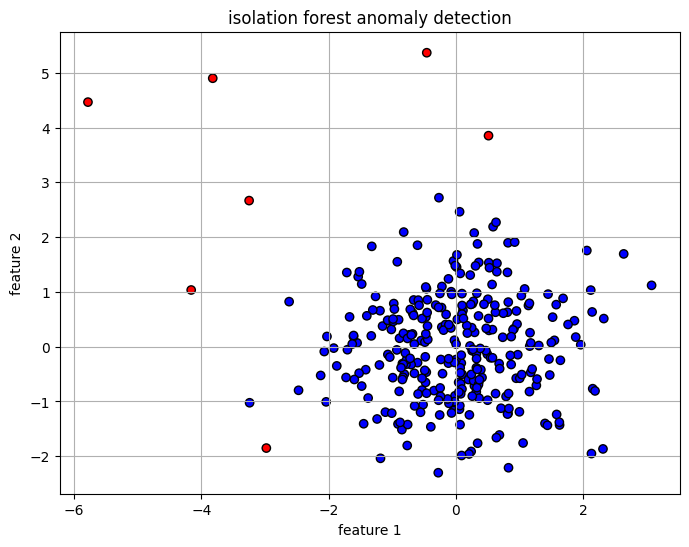

In [ ]:
# color points: red for anomaly, blue for normal
colors = ['red' if label else 'blue' for label in labels]

# plot all points
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=colors, edgecolors='k')
plt.title("isolation forest anomaly detection")
plt.xlabel("feature 1")
plt.ylabel("feature 2")
plt.grid(True)
plt.show()
